<a href="https://colab.research.google.com/github/HamidrezaKmK/2times2048/blob/master/src/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing


The following code reads 200 samples from Dr. Shahab dataset and 200 samples from UFBA dataset randomly and displays one sample from the selected.

In [14]:
### YOU SHOULD HAVE ACCESS TO THE DATABASE TO RUN THE FOLLOWING CODES ###

# Mount on drive for google colab use
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


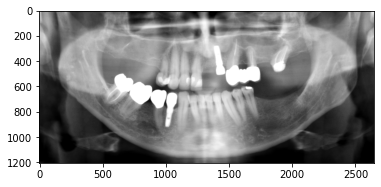

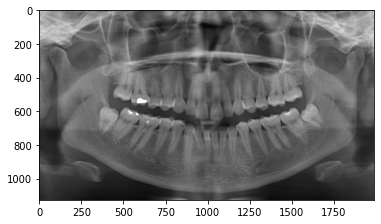

In [29]:
plt.imshow(samples_shahab[0], cmap='gray')
plt.show()
plt.imshow(samples_brazil[0], cmap='gray')
plt.show()

In [28]:
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random

# Change to a directory containing Dr.Shahab images:
path_to_dr_shahab = '/content/drive/MyDrive/WORK/Dr Shahab/2021_01/' 

shahab_images = os.listdir(path_to_dr_shahab)
# Change to a directory containing the UFBA images
path_to_brazil = '/content/drive/MyDrive/WORK/UFBA/all_images/'

brazil_images = os.listdir(path_to_brazil)

samples_shahab = []
samples_brazil = []
sample_size_shahab = min(len(shahab_images), 200)
sample_size_brazil = min(len(brazil_images), 200)

for x in random.sample(shahab_images, sample_size_shahab):
  t = cv2.imread(os.path.join(path_to_dr_shahab, x), cv2.IMREAD_GRAYSCALE)
  samples_shahab.append(t)

for x in random.sample(brazil_images, sample_size_brazil):
  t = cv2.imread(os.path.join(path_to_brazil, x), cv2.IMREAD_GRAYSCALE)
  samples_brazil.append(t)


### Histogram matching and equalization
In the remainder, we can explore different ways of addressing this problem.
A simple way is to perform a mapping between different pixel intensities; which
is known as **histogram equalization**. In this method, assume we are
trying to obtain a mapping from images coming from $\Gamma'$ to
$\Gamma$. We may approximate the Cumulative Density Function (CDF) 
of pixel intensities ranging from 0 to 255 for each of the $\Gamma$
and $\Gamma'$; we can refer to these CDF functions as $F$ and $F'$.
Intensity $x$ from the first dataset is mapped to $F'^{-1} o F(x)$.
Using this simple method we may obtain images similar to $\Gamma$ from
$\Gamma'$.

Run the following piece of code to get the cdf function from both randomly sampled data.

In [40]:
from tqdm import tqdm

def get_cdf(list_of_images):
  """
  Gets a list of images and returns the cdf of the intensity distribution
  """
  cdf = np.zeros(256)
  for img in tqdm(list_of_images):
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        cdf[img[i,j]] += 1
  cdf = cdf.astype('float64')
  cdf /= cdf.sum()
  for i in range(1, len(cdf)):
    cdf[i] += cdf[i-1]
  return cdf

In [41]:
cdf_brazil = get_cdf(samples_brazil)
cdf_shahab = get_cdf(samples_shahab)

100%|██████████| 200/200 [06:54<00:00,  2.07s/it]


Next, we try to obtain a histogram equalization mapping between the two dataset using the method described above.

In [42]:
shahab_to_brazil = np.zeros(256)
pnt = 0
for i in range(256):
  while pnt < 256 and cdf_brazil[pnt] < cdf_shahab[i]:
    pnt += 1
  shahab_to_brazil[i] = pnt
  if pnt == 256 or (pnt > 0 and abs(cdf_brazil[pnt-1] - cdf_shahab[i]) < 
                    abs(cdf_brazil[pnt] - cdf_shahab[i])):
    shahab_to_brazil[i] = pnt - 1

In [91]:
#np.save('/content/drive/MyDrive/WORK/mapping.npy', shahab_to_brazil)
np.load('/content/drive/MyDrive/WORK/mapping.npy', shahab_to_brazil)

Finally, we display an image from Dr. Shahab database and a random image from UFBA dataset; afterward, we map each pixel from the first image to obtain a similar dynamic range to UFBA.

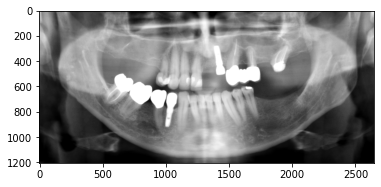

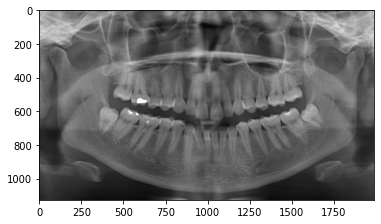

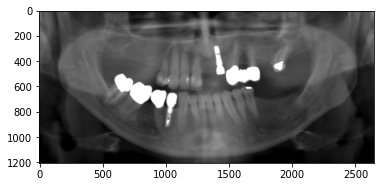

In [44]:
img = samples_shahab[0]
plt.imshow(img, cmap='gray')
plt.show()
img_standard = samples_brazil[0]
plt.imshow(img_standard, cmap='gray')
plt.show()
def convert(mapping, img_input):
  img_output = np.zeros_like(img_input)
  for x in range(img_output.shape[0]):
    for y in range(img_output.shape[1]):
      img_output[x, y] = mapping[img_input[x,y]]
  return img_output
img_standardized = convert(shahab_to_brazil, img)
plt.imshow(img_standardized, cmap='gray')
plt.show()

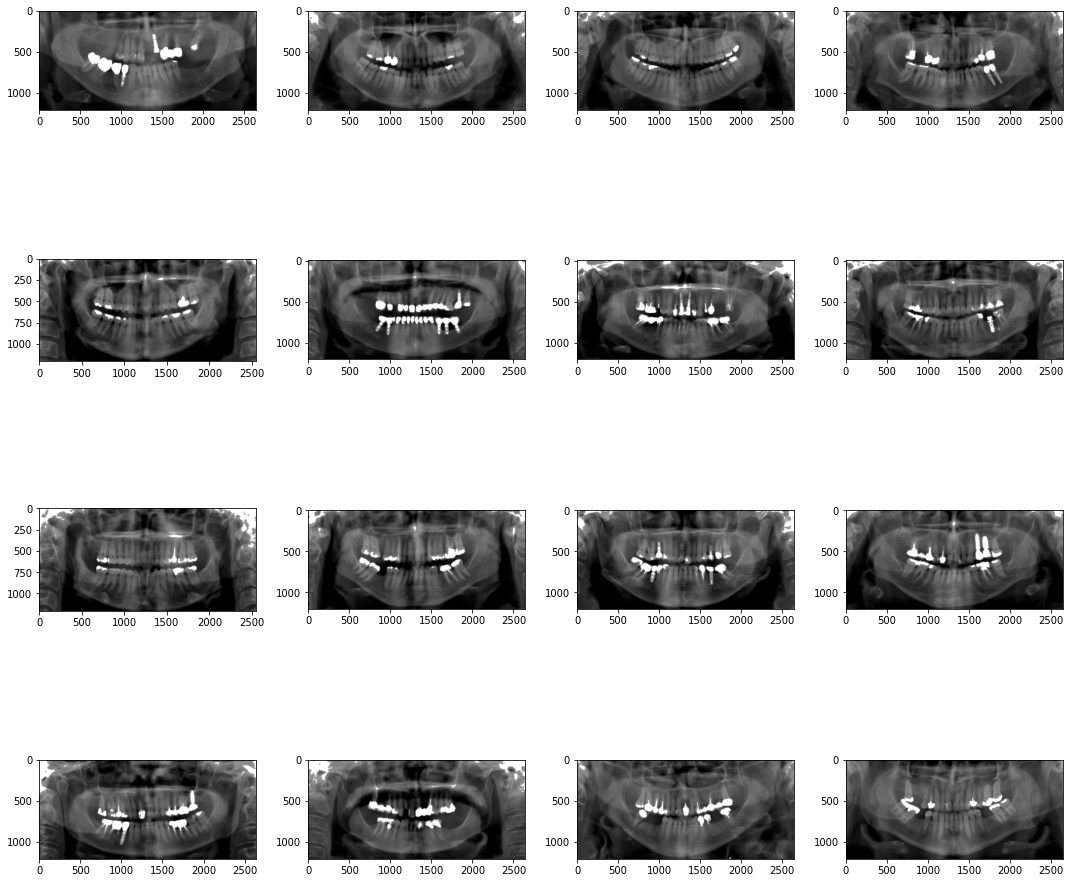

In [55]:
fig = plt.figure(figsize=(15, 15))
axes = []
for i, img in enumerate(samples_shahab[:16]):
  axes.append(fig.add_subplot(4, 4, i + 1))
  plt.imshow(convert(shahab_to_brazil, img) , cmap='gray')
fig.tight_layout()
plt.show()

One problem with the mapping based methods is that pixel intensity $x$ is mapped to a particular intensity $y$ regardless of its location in the photo. For example, in the previous 16 samples, you may see parts of the gingival tissue or the spine being colored as bright white that represents restorations on tooth.

On the other hand, there are sharp increases in the pixel intensity of each photo regardless of the surrounding.

### Gamma correction method

Many devices are used for capturing, printing or displaying the images
generally apply a transformation called the power-law; the image of
each pixel of the image has a nonlinear effect on limunance:
$$g(u) = u^\gamma$$
In the above equation, $u \in [0, 1]$ denotes the pixel intensity,
$\gamma$ is a positive constant introducing the gamma value. This equation using the value of
$\gamma$ typically can be determined experimentally
through passing a calibration target with a full
range of known luminance, which values through
the imaging device.




[link](http://jad.shahroodut.ac.ir/article_112_39a9dc559a9e7dddb43fbdbded89d7e5.pdf)

In [83]:
def calc_GLCM(img):
  GLCM = np.zeros((256, 256))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      for d1 in [-1, 0, 1, 0]:
        for d2 in [0, 1, 0, -1]:
          r, c = i + d1, j + d2
          if 0 <= r < img.shape[0] and 0 <= c < img.shape[1]:
            GLCM[img[i,j], img[r, c]] += 1
  return GLCM

In [73]:
def calc_homogenity(GLCM):
  ret = 0.0
  for i in range(GLCM.shape[0]):
    for j in range(GLCM.shape[1]):
      ret += GLCM[i, j] / (abs(i - j) + 1)
  return ret

In [80]:
print(samples_shahab[0].dtype)

uint8


In [81]:
def gamma_transform(img, gamma):
  return np.round((img.astype('float64')/256) ** gamma * 256).astype('uint8')

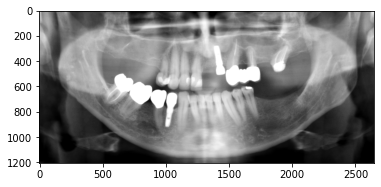

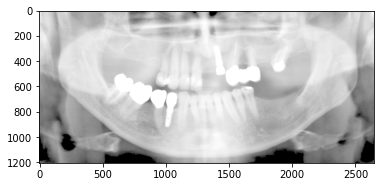

In [65]:
plt.imshow(samples_shahab[0], cmap='gray')
plt.show()
changed = gamma_transform(samples_shahab[0], 0.3)
plt.imshow(changed, cmap='gray')
plt.show()

In [67]:
np.linspace(0.1, 3, 30)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [86]:
from math import inf

def calc_best_gamma(img):
  best_gamma = 0.1
  best_HOM = inf
  for gamma in tqdm(np.linspace(0.1, 3, 30)):
    changed = gamma_transform(img, gamma)
    t = calc_homogenity(calc_GLCM(changed))
    if t < best_HOM:
      best_gamma = gamma
      best_HOM = t
  return best_gamma

In [90]:
import skimage 
from skimage.feature import graycomatrix
glcm = graycomatrix(samples_shahab, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-14249bfec76f>", line 2, in <module>
    from skimage.feature import graycomatrix
  File "/usr/local/lib/python3.7/dist-packages/skimage/feature/__init__.py", line 24, in <module>
    from .orb import ORB
  File "/usr/local/lib/python3.7/dist-packages/skimage/feature/orb.py", line 12, in <module>
    from .orb_cy import _orb_loop
  File "skimage/feature/orb_cy.pyx", line 13, in init skimage.feature.orb_cy
  File "/usr/local/lib/python3.7/dist-packages/skimage/feature/_orb_descriptor_positions.py", line 9, in <module>
    dtype=np.int8)
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 1067, in loadtxt
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/_datasource.py", line 192, 

FileNotFoundError: ignored